### Computer Vision

#### BY :- 

### 1- Abd-Elhady Saeed Afify 
### 2- Ali Zakaria Ibrahim
### 3- Alaa Ahmed Nabil  
### 4- Abdel - Mageed Mohamed Afwat

--------------------------------------------------
--------------------------------------------------

#### IMPORT LIBERARIES

In [ ]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

#### PREPARE DATASERT

In [35]:
import os
from sklearn.datasets import load_files
import pandas as pd
print(os.getcwd() + r'\videos')
raw_data = load_files(os.getcwd() + r'\dataset', shuffle=False)
print(raw_data)
files = raw_data['filenames']
files

C:\Users\hadys\vision\videos


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



array(['C:\\Users\\hadys\\vision\\dataset\\bend\\daria_bend.avi',
       'C:\\Users\\hadys\\vision\\dataset\\bend\\denis_bend.avi',
       'C:\\Users\\hadys\\vision\\dataset\\bend\\eli_bend.avi',
       'C:\\Users\\hadys\\vision\\dataset\\bend\\ido_bend.avi',
       'C:\\Users\\hadys\\vision\\dataset\\bend\\ira_bend.avi',
       'C:\\Users\\hadys\\vision\\dataset\\bend\\lena_bend.avi',
       'C:\\Users\\hadys\\vision\\dataset\\bend\\lyova_bend.avi',
       'C:\\Users\\hadys\\vision\\dataset\\bend\\moshe_bend.avi',
       'C:\\Users\\hadys\\vision\\dataset\\bend\\shahar_bend.avi',
       'C:\\Users\\hadys\\vision\\dataset\\jack\\daria_jack.avi',
       'C:\\Users\\hadys\\vision\\dataset\\jack\\denis_jack.avi',
       'C:\\Users\\hadys\\vision\\dataset\\jack\\eli_jack.avi',
       'C:\\Users\\hadys\\vision\\dataset\\jack\\ido_jack.avi',
       'C:\\Users\\hadys\\vision\\dataset\\jack\\ira_jack.avi',
       'C:\\Users\\hadys\\vision\\dataset\\jack\\lena_jack.avi',
       'C:\\Users\\hady

In [36]:
def extract_tag(video_path):
    return (video_path.split("_")[1]).split(".")[0]

In [37]:
data = pd.DataFrame()
data["video_name"] = files
data["tag"] = data["video_name"].apply(extract_tag)

data

,video_name,tag
0,C:\Users\hadys\vision\dataset\bend\daria_bend.avi,bend
1,C:\Users\hadys\vision\dataset\bend\denis_bend.avi,bend
2,C:\Users\hadys\vision\dataset\bend\eli_bend.avi,bend
3,C:\Users\hadys\vision\dataset\bend\ido_bend.avi,bend
4,C:\Users\hadys\vision\dataset\bend\ira_bend.avi,bend
...,...,...
88,C:\Users\hadys\vision\dataset\wave2\ira_wave2.avi,wave2
89,C:\Users\hadys\vision\dataset\wave2\lena_wave2...,wave2
90,C:\Users\hadys\vision\dataset\wave2\lyova_wave...,wave2
91,C:\Users\hadys\vision\dataset\wave2\moshe_wave...,wave2


In [38]:
training=data.sample(frac=0.7,random_state=200) #random state is a seed value
testing=data.drop(training.index)

In [39]:
testing.to_csv("tesing.csv")
training.to_csv("training.csv")

#### TRAINING

In [6]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 500

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [48]:
train_df = pd.read_csv("training.csv")
test_df = pd.read_csv("tesing.csv")
print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

Total videos for training: 74
Total videos for testing: 19


In [49]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [50]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

In [51]:
label_processor = keras.layers.experimental.preprocessing.StringLookup(
    num_oov_indices=0,vocabulary=train_df.tag.unique()
)
print(label_processor.get_vocabulary())

['run', 'bend', 'walk', 'skip', 'jump', 'wave1', 'jack', 'side', 'pjump', 'wave2']


In [52]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

1/1 [==============================] - 0s 202ms/step


1/1 [==============================] - 0s 150ms/step


1/1 [==============================] - 0s 151ms/step


1/1 [==============================] - 0s 186ms/step


1/1 [==============================] - 0s 114ms/step


1/1 [==============================] - 0s 116ms/step


1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 117ms/step


1/1 [==============================] - 0s 116ms/step


1/1 [==============================] - 0s 123ms/step


1/1 [==============================] - 0s 116ms/step


1/1 [==============================] - 0s 117ms/step


1/1 [==============================] - 0s 117ms/step
Frame features in train set: (74, 20, 2048)
Frame masks in train set: (74, 20)


In [168]:
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "./tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=420,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model




In [169]:
_, sequence_model = run_experiment()

Epoch 1/420
2/2 [==============================] - ETA: 0s - loss: 2.2888 - accuracy: 0.1373
Epoch 1: val_loss improved from inf to 2.29321, saving model to ./tmp\video_classifier
2/2 [==============================] - 8s 2s/step - loss: 2.2888 - accuracy: 0.1373 - val_loss: 2.2932 - val_accuracy: 0.2174
Epoch 2/420
2/2 [==============================] - ETA: 0s - loss: 2.2691 - accuracy: 0.1765
Epoch 2: val_loss improved from 2.29321 to 2.25853, saving model to ./tmp\video_classifier
2/2 [==============================] - 0s 178ms/step - loss: 2.2691 - accuracy: 0.1765 - val_loss: 2.2585 - val_accuracy: 0.1739
Epoch 3/420
2/2 [==============================] - ETA: 0s - loss: 2.2562 - accuracy: 0.1765
Epoch 3: val_loss improved from 2.25853 to 2.24632, saving model to ./tmp\video_classifier
2/2 [==============================] - 0s 173ms/step - loss: 2.2562 - accuracy: 0.1765 - val_loss: 2.2463 - val_accuracy: 0.1304
Epoch 4/420
2/2 [==============================] - ETA: 0s - loss: 2

2/2 [==============================] - ETA: 0s - loss: 0.7681 - accuracy: 0.7647
Epoch 27: val_loss improved from 1.23206 to 1.15033, saving model to ./tmp\video_classifier
2/2 [==============================] - 0s 164ms/step - loss: 0.7681 - accuracy: 0.7647 - val_loss: 1.1503 - val_accuracy: 0.5652
Epoch 28/420
2/2 [==============================] - ETA: 0s - loss: 0.8155 - accuracy: 0.7647
Epoch 28: val_loss improved from 1.15033 to 1.09243, saving model to ./tmp\video_classifier
2/2 [==============================] - 0s 168ms/step - loss: 0.8155 - accuracy: 0.7647 - val_loss: 1.0924 - val_accuracy: 0.6087
Epoch 29/420
2/2 [==============================] - ETA: 0s - loss: 0.8173 - accuracy: 0.7451
Epoch 29: val_loss did not improve from 1.09243
2/2 [==============================] - 0s 105ms/step - loss: 0.8173 - accuracy: 0.7451 - val_loss: 1.1046 - val_accuracy: 0.5217
Epoch 30/420
2/2 [==============================] - ETA: 0s - loss: 0.6845 - accuracy: 0.8235
Epoch 30: val_loss

Epoch 56/420
2/2 [==============================] - ETA: 0s - loss: 0.3695 - accuracy: 0.8627
Epoch 56: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 105ms/step - loss: 0.3695 - accuracy: 0.8627 - val_loss: 1.0551 - val_accuracy: 0.7391
Epoch 57/420
2/2 [==============================] - ETA: 0s - loss: 0.2072 - accuracy: 0.9608
Epoch 57: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 105ms/step - loss: 0.2072 - accuracy: 0.9608 - val_loss: 1.0585 - val_accuracy: 0.7391
Epoch 58/420
2/2 [==============================] - ETA: 0s - loss: 0.4273 - accuracy: 0.8039
Epoch 58: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 109ms/step - loss: 0.4273 - accuracy: 0.8039 - val_loss: 1.0495 - val_accuracy: 0.8261
Epoch 59/420
2/2 [==============================] - ETA: 0s - loss: 0.5303 - accuracy: 0.8039
Epoch 59: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 105

2/2 [==============================] - ETA: 0s - loss: 0.3159 - accuracy: 0.8627
Epoch 86: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 105ms/step - loss: 0.3159 - accuracy: 0.8627 - val_loss: 1.0166 - val_accuracy: 0.6957
Epoch 87/420
2/2 [==============================] - ETA: 0s - loss: 0.3044 - accuracy: 0.8431
Epoch 87: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 107ms/step - loss: 0.3044 - accuracy: 0.8431 - val_loss: 1.1609 - val_accuracy: 0.6957
Epoch 88/420
2/2 [==============================] - ETA: 0s - loss: 0.2574 - accuracy: 0.9216
Epoch 88: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 106ms/step - loss: 0.2574 - accuracy: 0.9216 - val_loss: 1.0443 - val_accuracy: 0.7391
Epoch 89/420
2/2 [==============================] - ETA: 0s - loss: 0.2715 - accuracy: 0.9216
Epoch 89: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 101ms/step - los

2/2 [==============================] - ETA: 0s - loss: 0.3931 - accuracy: 0.8431
Epoch 116: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 107ms/step - loss: 0.3931 - accuracy: 0.8431 - val_loss: 1.0744 - val_accuracy: 0.6522
Epoch 117/420
2/2 [==============================] - ETA: 0s - loss: 0.3236 - accuracy: 0.8235
Epoch 117: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 108ms/step - loss: 0.3236 - accuracy: 0.8235 - val_loss: 1.2378 - val_accuracy: 0.6087
Epoch 118/420
2/2 [==============================] - ETA: 0s - loss: 0.2676 - accuracy: 0.8627
Epoch 118: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 105ms/step - loss: 0.2676 - accuracy: 0.8627 - val_loss: 1.2953 - val_accuracy: 0.6522
Epoch 119/420
2/2 [==============================] - ETA: 0s - loss: 0.2187 - accuracy: 0.9216
Epoch 119: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 106ms/ste

2/2 [==============================] - ETA: 0s - loss: 0.2150 - accuracy: 0.9020
Epoch 146: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 106ms/step - loss: 0.2150 - accuracy: 0.9020 - val_loss: 1.1626 - val_accuracy: 0.7391
Epoch 147/420
2/2 [==============================] - ETA: 0s - loss: 0.1532 - accuracy: 0.9608
Epoch 147: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 107ms/step - loss: 0.1532 - accuracy: 0.9608 - val_loss: 1.1730 - val_accuracy: 0.6522
Epoch 148/420
2/2 [==============================] - ETA: 0s - loss: 0.1589 - accuracy: 0.9216
Epoch 148: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 106ms/step - loss: 0.1589 - accuracy: 0.9216 - val_loss: 1.1559 - val_accuracy: 0.6957
Epoch 149/420
2/2 [==============================] - ETA: 0s - loss: 0.2731 - accuracy: 0.9216
Epoch 149: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 103ms/ste

2/2 [==============================] - ETA: 0s - loss: 0.2828 - accuracy: 0.8824
Epoch 176: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 107ms/step - loss: 0.2828 - accuracy: 0.8824 - val_loss: 1.2436 - val_accuracy: 0.6957
Epoch 177/420
2/2 [==============================] - ETA: 0s - loss: 0.3480 - accuracy: 0.8431
Epoch 177: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 105ms/step - loss: 0.3480 - accuracy: 0.8431 - val_loss: 1.2073 - val_accuracy: 0.6957
Epoch 178/420
2/2 [==============================] - ETA: 0s - loss: 0.1463 - accuracy: 0.9412
Epoch 178: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 106ms/step - loss: 0.1463 - accuracy: 0.9412 - val_loss: 1.2499 - val_accuracy: 0.7391
Epoch 179/420
2/2 [==============================] - ETA: 0s - loss: 0.1716 - accuracy: 0.9608
Epoch 179: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 105ms/ste

2/2 [==============================] - ETA: 0s - loss: 0.3024 - accuracy: 0.9020
Epoch 206: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 107ms/step - loss: 0.3024 - accuracy: 0.9020 - val_loss: 1.2655 - val_accuracy: 0.6522
Epoch 207/420
2/2 [==============================] - ETA: 0s - loss: 0.2522 - accuracy: 0.8431
Epoch 207: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 105ms/step - loss: 0.2522 - accuracy: 0.8431 - val_loss: 1.1995 - val_accuracy: 0.7826
Epoch 208/420
2/2 [==============================] - ETA: 0s - loss: 0.1937 - accuracy: 0.9216
Epoch 208: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 100ms/step - loss: 0.1937 - accuracy: 0.9216 - val_loss: 1.1308 - val_accuracy: 0.7826
Epoch 209/420
2/2 [==============================] - ETA: 0s - loss: 0.2246 - accuracy: 0.9216
Epoch 209: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 104ms/ste

2/2 [==============================] - ETA: 0s - loss: 0.1082 - accuracy: 0.9608
Epoch 236: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 107ms/step - loss: 0.1082 - accuracy: 0.9608 - val_loss: 1.3330 - val_accuracy: 0.6957
Epoch 237/420
2/2 [==============================] - ETA: 0s - loss: 0.1855 - accuracy: 0.9216
Epoch 237: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 108ms/step - loss: 0.1855 - accuracy: 0.9216 - val_loss: 1.4548 - val_accuracy: 0.6087
Epoch 238/420
2/2 [==============================] - ETA: 0s - loss: 0.1767 - accuracy: 0.9412
Epoch 238: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 112ms/step - loss: 0.1767 - accuracy: 0.9412 - val_loss: 1.2580 - val_accuracy: 0.7826
Epoch 239/420
2/2 [==============================] - ETA: 0s - loss: 0.0843 - accuracy: 0.9804
Epoch 239: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 107ms/ste

2/2 [==============================] - ETA: 0s - loss: 0.1383 - accuracy: 0.9804
Epoch 266: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 105ms/step - loss: 0.1383 - accuracy: 0.9804 - val_loss: 1.3181 - val_accuracy: 0.7391
Epoch 267/420
2/2 [==============================] - ETA: 0s - loss: 0.2910 - accuracy: 0.8824
Epoch 267: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 106ms/step - loss: 0.2910 - accuracy: 0.8824 - val_loss: 1.3554 - val_accuracy: 0.6957
Epoch 268/420
2/2 [==============================] - ETA: 0s - loss: 0.2283 - accuracy: 0.9412
Epoch 268: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 105ms/step - loss: 0.2283 - accuracy: 0.9412 - val_loss: 1.3665 - val_accuracy: 0.6522
Epoch 269/420
2/2 [==============================] - ETA: 0s - loss: 0.1483 - accuracy: 0.9412
Epoch 269: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 106ms/ste

2/2 [==============================] - ETA: 0s - loss: 0.1944 - accuracy: 0.9020
Epoch 296: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 105ms/step - loss: 0.1944 - accuracy: 0.9020 - val_loss: 1.6471 - val_accuracy: 0.6087
Epoch 297/420
2/2 [==============================] - ETA: 0s - loss: 0.2285 - accuracy: 0.8627
Epoch 297: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 105ms/step - loss: 0.2285 - accuracy: 0.8627 - val_loss: 2.2704 - val_accuracy: 0.4783
Epoch 298/420
2/2 [==============================] - ETA: 0s - loss: 0.1771 - accuracy: 0.9412
Epoch 298: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 109ms/step - loss: 0.1771 - accuracy: 0.9412 - val_loss: 2.2629 - val_accuracy: 0.5652
Epoch 299/420
2/2 [==============================] - ETA: 0s - loss: 0.1867 - accuracy: 0.9412
Epoch 299: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 107ms/ste

2/2 [==============================] - ETA: 0s - loss: 0.1628 - accuracy: 0.9412
Epoch 326: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 130ms/step - loss: 0.1628 - accuracy: 0.9412 - val_loss: 1.5281 - val_accuracy: 0.6957
Epoch 327/420
2/2 [==============================] - ETA: 0s - loss: 0.2983 - accuracy: 0.8824
Epoch 327: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 118ms/step - loss: 0.2983 - accuracy: 0.8824 - val_loss: 1.6112 - val_accuracy: 0.6522
Epoch 328/420
2/2 [==============================] - ETA: 0s - loss: 0.0993 - accuracy: 0.9608
Epoch 328: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 117ms/step - loss: 0.0993 - accuracy: 0.9608 - val_loss: 1.5761 - val_accuracy: 0.6522
Epoch 329/420
2/2 [==============================] - ETA: 0s - loss: 0.0502 - accuracy: 1.0000
Epoch 329: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 122ms/ste

2/2 [==============================] - ETA: 0s - loss: 0.1699 - accuracy: 0.9608
Epoch 356: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 127ms/step - loss: 0.1699 - accuracy: 0.9608 - val_loss: 1.4075 - val_accuracy: 0.7391
Epoch 357/420
2/2 [==============================] - ETA: 0s - loss: 0.0759 - accuracy: 0.9804
Epoch 357: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 111ms/step - loss: 0.0759 - accuracy: 0.9804 - val_loss: 1.4163 - val_accuracy: 0.7391
Epoch 358/420
2/2 [==============================] - ETA: 0s - loss: 0.1480 - accuracy: 0.9608
Epoch 358: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 115ms/step - loss: 0.1480 - accuracy: 0.9608 - val_loss: 1.4077 - val_accuracy: 0.7391
Epoch 359/420
2/2 [==============================] - ETA: 0s - loss: 0.2274 - accuracy: 0.8627
Epoch 359: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 118ms/ste

2/2 [==============================] - ETA: 0s - loss: 0.2107 - accuracy: 0.9020
Epoch 386: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 120ms/step - loss: 0.2107 - accuracy: 0.9020 - val_loss: 1.9467 - val_accuracy: 0.6087
Epoch 387/420
2/2 [==============================] - ETA: 0s - loss: 0.1394 - accuracy: 0.9216
Epoch 387: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 118ms/step - loss: 0.1394 - accuracy: 0.9216 - val_loss: 1.9802 - val_accuracy: 0.6087
Epoch 388/420
2/2 [==============================] - ETA: 0s - loss: 0.2367 - accuracy: 0.9020
Epoch 388: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 117ms/step - loss: 0.2367 - accuracy: 0.9020 - val_loss: 2.0556 - val_accuracy: 0.6087
Epoch 389/420
2/2 [==============================] - ETA: 0s - loss: 0.1852 - accuracy: 0.9216
Epoch 389: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 121ms/ste

2/2 [==============================] - ETA: 0s - loss: 0.0964 - accuracy: 0.9412
Epoch 416: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 124ms/step - loss: 0.0964 - accuracy: 0.9412 - val_loss: 1.5910 - val_accuracy: 0.7391
Epoch 417/420
2/2 [==============================] - ETA: 0s - loss: 0.1457 - accuracy: 0.9216
Epoch 417: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 124ms/step - loss: 0.1457 - accuracy: 0.9216 - val_loss: 1.6272 - val_accuracy: 0.6957
Epoch 418/420
2/2 [==============================] - ETA: 0s - loss: 0.2695 - accuracy: 0.8824
Epoch 418: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 121ms/step - loss: 0.2695 - accuracy: 0.8824 - val_loss: 1.6661 - val_accuracy: 0.6957
Epoch 419/420
2/2 [==============================] - ETA: 0s - loss: 0.1649 - accuracy: 0.9412
Epoch 419: val_loss did not improve from 0.77965
2/2 [==============================] - 0s 124ms/ste

#### TESTING

Test video path: C:\Users\hadys\vision\dataset\bend\denis_bend.avi
1/1 [==============================] - 0s 23ms/step
  bend: 82.75%
  jump: 12.62%
  wave1:  2.69%
  wave2:  0.88%
  skip:  0.66%
  run:  0.15%
  walk:  0.12%
  jack:  0.08%
  pjump:  0.03%
  side:  0.01%



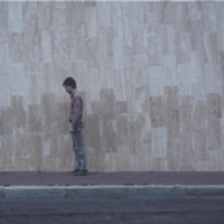

In [179]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

In [180]:
print('thankyou')

thankyou
